In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import skimage.io as io
import skimage.transform as trans
import torch.nn as nn
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')

c = tf.matmul(a, b)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

C:\Users\Tao\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data exploration and preprocessing
There are 27 images in total. Some of the input cell image having 3 or 4 channels, which is unnessary for segmentation, we need to transfer to grayscale.

Also some masks are having same channel issue, as well as, numerical difference on different images. Some image's pixel range from 0 to 1, some from 0 to 255. We need to normalize them with same scale.

Also some masks have 0 as backgrounds, some may have 1 as backgrounds, we need to unify them. 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
(27, 256, 256)
1.0 0.0


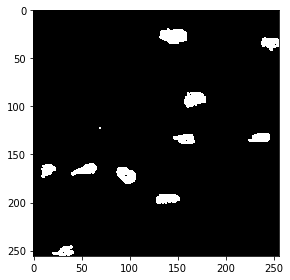

1
1.0 0.0


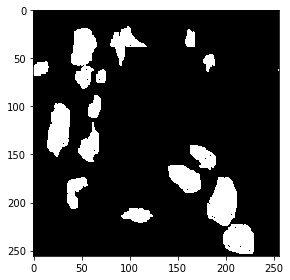

2
1.0 0.0


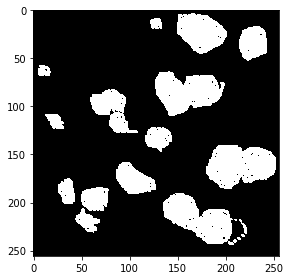

3
1.0 0.0


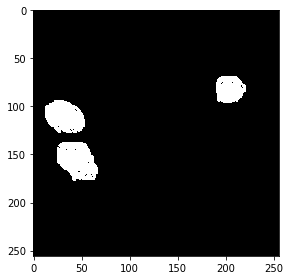

4
1.0 0.0


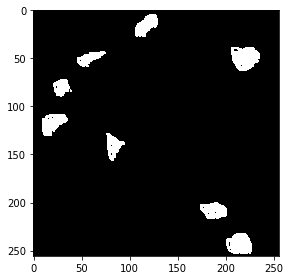

5
1.0 0.0


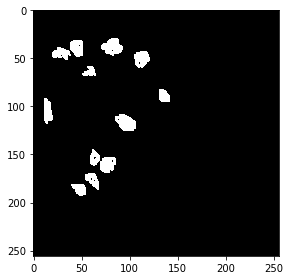

6
1.0 0.0


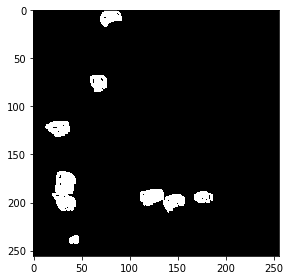

7
1.0 0.0


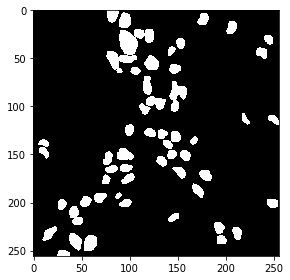

8
1.0 0.0


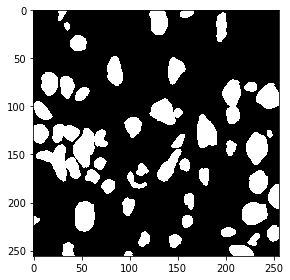

9
1.0 0.0


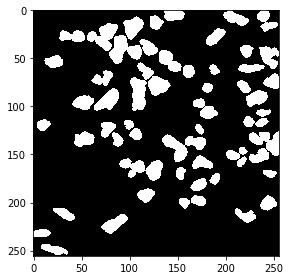

10
1.0 0.0


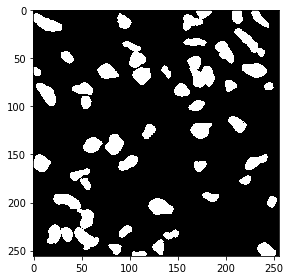

11
1.0 0.0


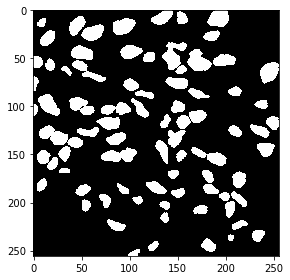

12
1.0 0.0


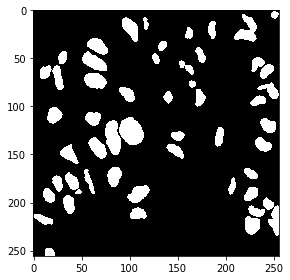

13
1.0 0.0


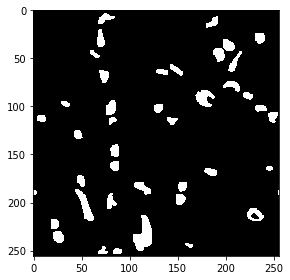

14
1.0 0.0


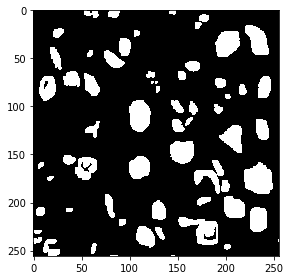

15
1.0 0.0


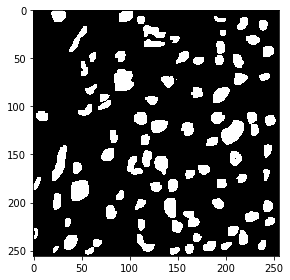

16
1.0 0.0


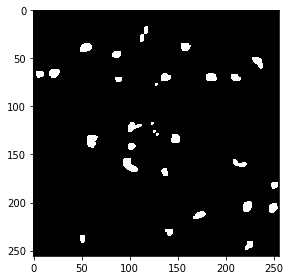

17
1.0 0.0


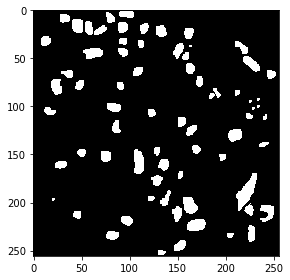

18
1.0 0.0


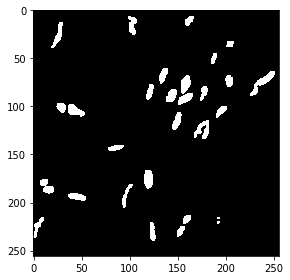

19
1.0 0.0


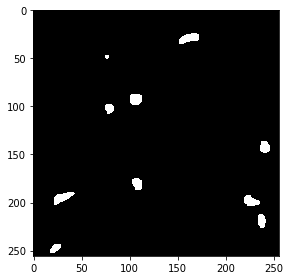

20
1.0 0.0


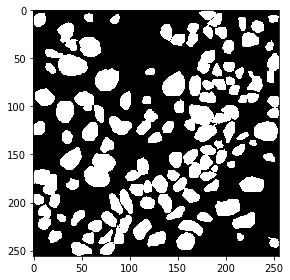

21
1.0 0.0


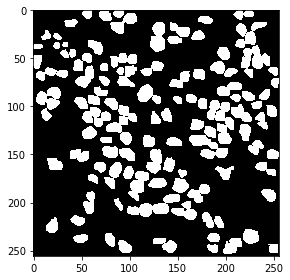

22
1.0 0.0


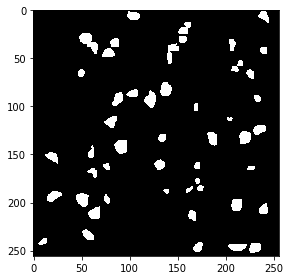

23
1.0 0.0


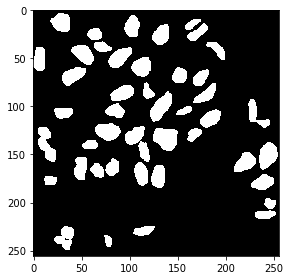

24
1.0 0.0


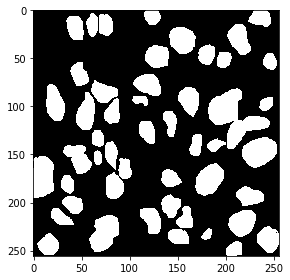

25
1.0 0.0


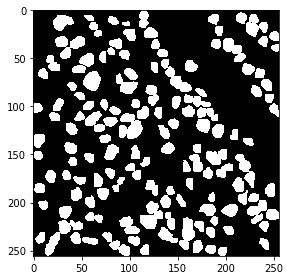

26
1.0 0.0


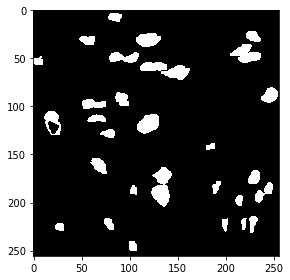

27
(27, 256, 256)


In [23]:
#clean and manipulate data

import skimage
from skimage.io import *
from skimage.color import *
from skimage.filters import threshold_otsu
rang = [i for i in range(1,28)]
print(rang)
#im.show()
def read_img(img_dir):
    imgs = []
    for i in rang:
        img_ = img_dir + 'patch' + str(i) + '.tif'
        try:
            imgs.append(imread(img_))
        except:
            img_ = img_dir + 'patch' + str(i) + '.tiff'
            imgs.append(imread(img_))
            
    return imgs


def read_mask(mask_dir):
    imgs = []
    print(rang)
    for i in rang:
        img_ = mask_dir + 'mask' + str(i) + '.tif'
        try:
            imgs.append(imread(img_))
        except:
            img_ = mask_dir + 'mask' + str(i) + '.tiff'
            imgs.append(imread(img_))
        
    return imgs

org_imgs = read_img('cell_data/')
mask_imgs = read_mask('cell_data/')

def normalize(x):
    a = x.shape
    x.reshape(-1,1)
    #print(x.shape)
    x = (x - x.min()) / (x.max() - x.min())
    #x = (x - x.mean())/x.std()
    x.reshape(a)
    return x

#transfer from rgb with 3 or 4 channels to grayscale
org_imgs = [rgb2gray(i) for i in org_imgs]
org_imgs = [normalize(i) for i in org_imgs]
org_imgs = np.asarray(org_imgs)
np.save('cell_data/org_imgs.npy',org_imgs )
print(org_imgs.shape)


def print_img(imgs):
    j = 0
    for i in imgs:
        print(np.max(i), np.min(i))
        j += 1
        imshow(i)
        plt.show()
        print(j)
def binary(imgs):
    result = []
    for i in imgs:
        #print(np.max(i), np.min(i))
        thresh = threshold_otsu(i)
        binary = i > thresh
        result.append(binary)
    return result

mask_imgs = [rgb2gray(i) for i in mask_imgs]
#mask_imgs = [np.asarray(binary(i)) for i in mask_imgs]
#mask_imgs = [normalize(i) for i in mask_imgs]

mask_imgs = np.asarray(mask_imgs)

mask_imgs[mask_imgs > 0] = 1

#flip none zero backgrounds to zeros
k = np.zeros(mask_imgs.shape)
ones = np.ones(mask_imgs[0].shape)
for i in range(mask_imgs.shape[0]):
    if i >12 and i <20:
        k[i] = ones - mask_imgs[i]
    else:
        k[i] = mask_imgs[i]

print_img(k)


#mask_imgs = [normalize(i) for i in mask_imgs]
np.save('cell_data/mask_imgs.npy', k)

mask_imgs = np.load('cell_data/mask_imgs.npy')
print(mask_imgs.shape)


In [3]:
# train test split
from sklearn.model_selection import train_test_split
X = np.load('cell_data/org_imgs.npy')
y = np.load('cell_data/mask_imgs.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = np.reshape(X_train, (21, 256, 256, 1))
X_test = np.reshape(X_test, (6, 256, 256, 1))

y_train = np.reshape(y_train, (21, 256, 256, 1))
y_test = np.reshape(y_test, (6, 256, 256, 1))

print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

(27, 256, 256) (27, 256, 256) (21, 256, 256) (6, 256, 256) (21, 256, 256) (6, 256, 256)
(27, 256, 256) (27, 256, 256) (21, 256, 256, 1) (6, 256, 256, 1) (21, 256, 256, 1) (6, 256, 256, 1)
0.0 1.0 0.0 1.0


# Metric -  Intersection over Union 

The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
IoU(A,B)=A∩B/A∪B

In [4]:
from keras import backend as K
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

Using TensorFlow backend.


# Unet Model

In [5]:
"""import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.layers.merge import add, concatenate

from skimage.io import imsave
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


img_rows = 256
img_cols = 256


inputs = Input((img_rows, img_cols,1))

#conv1
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print("conv1 shape:",conv1.shape)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print("conv1 shape:",conv1.shape)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print("pool1 shape:",pool1.shape)

#conv2
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print("conv2 shape:",conv2.shape)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
print("conv2 shape:",conv2.shape)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print("pool2 shape:",pool2.shape)

#conv3
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
print("conv3 shape:",conv3.shape)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
print("conv3 shape:",conv3.shape)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print("pool3 shape:",pool3.shape)

#conv4
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#conv5 
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

#up6 
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
merge6 = concatenate([drop4,up6])
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)


#up7
#up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
merge7 = concatenate([conv3,up7])
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#up8        
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
merge8 = concatenate([conv2,up8])
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#up9
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
merge9 = concatenate([conv1,up9])
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

#conv10
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
model = Model(inputs = inputs, outputs = conv10)


model.summary()


model.compile(optimizer = Adam(lr = 0.0006), loss = 'binary_crossentropy', metrics = ['accuracy'])
"""

'import os \n#os.environ["CUDA_VISIBLE_DEVICES"] = "0"\nimport numpy as np\nfrom keras.models import *\nfrom keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D\nfrom keras.optimizers import *\nfrom keras.callbacks import ModelCheckpoint, LearningRateScheduler\nfrom keras import backend as keras\nfrom keras.layers.merge import add, concatenate\n\nfrom skimage.io import imsave\nimport os\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img\n\n\nimg_rows = 256\nimg_cols = 256\n\n\ninputs = Input((img_rows, img_cols,1))\n\n#conv1\nconv1 = Conv2D(64, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(inputs)\nprint("conv1 shape:",conv1.shape)\nconv1 = Conv2D(64, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(conv1)\nprint("conv1 shape:",conv1.shape)\npool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\nprint("pool1 shape:",pool1.shape)\n\n#conv2\nconv

# Unet convolutional layer with channel number reduced
31 million parameters are too much for my 2GB gpu laptop. 
I decided to reduce the number of channels for each layer.
 or  remove two blocks of CNN layers both from down and up side.

In [6]:
import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping

from keras import backend as keras
from keras.layers.merge import add, concatenate

from skimage.io import imsave
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


img_rows = 256
img_cols = 256


inputs = Input((img_rows, img_cols,1))

#conv1
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print("conv1 shape:",conv1.shape)
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print("conv1 shape:",conv1.shape)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print("pool1 shape:",pool1.shape)

#conv2
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print("conv2 shape:",conv2.shape)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
print("conv2 shape:",conv2.shape)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print("pool2 shape:",pool2.shape)

#conv3
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
print("conv3 shape:",conv3.shape)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
print("conv3 shape:",conv3.shape)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print("pool3 shape:",pool3.shape)

#conv4
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#conv5 with dropout
conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

#up6 
up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
merge6 = concatenate([drop4,up6])
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)


#up7
#up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
merge7 = concatenate([conv3,up7])
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#up8        
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
merge8 = concatenate([conv2,up8])
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#up9
up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
merge9 = concatenate([conv1,up9])
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

#conv10
conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
model = Model(inputs = inputs, outputs = conv10)


model.summary()

model.compile(optimizer = Adam(lr = 0.0005), loss = 'binary_crossentropy', metrics = [mean_iou])


conv1 shape: (?, 256, 256, 32)
conv1 shape: (?, 256, 256, 32)
pool1 shape: (?, 128, 128, 32)
conv2 shape: (?, 128, 128, 64)
conv2 shape: (?, 128, 128, 64)
pool2 shape: (?, 64, 64, 64)
conv3 shape: (?, 64, 64, 128)
conv3 shape: (?, 64, 64, 128)
pool3 shape: (?, 32, 32, 128)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 32)  9248        conv2d_1[0][0]                   
___________________

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
print(X_train.shape)


(21, 256, 256, 1)


# Data augmentation



In [8]:
from keras.preprocessing import image
BATCH_SIZE = 4
seed = 12

# train and mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed 
image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(y_train[:int(y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(y_train[:int(y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(y_train[int(y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(y_train[int(y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

# Train

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping

BATCH_SIZE = 3

print("loading data")
imgs_train, imgs_mask_train, imgs_test = X_train, y_train, X_test
print("loading data done")
model = model
print("got unet")

earlystopper = EarlyStopping(patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')

#loss_history = model.fit(imgs_train, imgs_mask_train, batch_size = BATCH_SIZE, epochs=20, verbose=1,validation_split=0.2, shuffle=True,  callbacks=[earlystopper, model_checkpoint])
loss_history = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=6, steps_per_epoch =50, epochs=50, callbacks=[ model_checkpoint])


loading data
loading data done
got unet
Fitting model...
Epoch 1/50
50/50 [==============================] - 38s - loss: 0.2877 - mean_iou: 0.4279 - val_loss: 0.2254 - val_mean_iou: 0.4282
Epoch 2/50
50/50 [==============================] - 38s - loss: 0.2844 - mean_iou: 0.4287 - val_loss: 0.2403 - val_mean_iou: 0.4309
Epoch 3/50
50/50 [==============================] - 38s - loss: 0.2735 - mean_iou: 0.4330 - val_loss: 0.2332 - val_mean_iou: 0.4350
Epoch 4/50
50/50 [==============================] - 38s - loss: 0.2743 - mean_iou: 0.4362 - val_loss: 0.2307 - val_mean_iou: 0.4374
Epoch 5/50
50/50 [==============================] - 39s - loss: 0.2713 - mean_iou: 0.4385 - val_loss: 0.2206 - val_mean_iou: 0.4393
Epoch 6/50
50/50 [==============================] - 39s - loss: 0.2576 - mean_iou: 0.4401 - val_loss: 0.2195 - val_mean_iou: 0.4409
Epoch 7/50
50/50 [==============================] - 39s - loss: 0.2449 - mean_iou: 0.4453 - val_loss: 0.2295 - val_mean_iou: 0.4516
Epoch 8/50
50/50 [=

50/50 [==============================] - 39s - loss: 0.1423 - mean_iou: 0.5796 - val_loss: 0.1967 - val_mean_iou: 0.5817
Epoch 30/50
50/50 [==============================] - 39s - loss: 0.1383 - mean_iou: 0.5838 - val_loss: 0.2248 - val_mean_iou: 0.5859
Epoch 31/50
50/50 [==============================] - 39s - loss: 0.1422 - mean_iou: 0.5875 - val_loss: 0.1998 - val_mean_iou: 0.5893
Epoch 32/50
50/50 [==============================] - 39s - loss: 0.1313 - mean_iou: 0.5912 - val_loss: 0.2110 - val_mean_iou: 0.5932
Epoch 33/50
50/50 [==============================] - 39s - loss: 0.1319 - mean_iou: 0.5951 - val_loss: 0.2081 - val_mean_iou: 0.5969
Epoch 34/50
50/50 [==============================] - 39s - loss: 0.1398 - mean_iou: 0.5987 - val_loss: 0.1877 - val_mean_iou: 0.6003
Epoch 35/50
50/50 [==============================] - 39s - loss: 0.1322 - mean_iou: 0.6016 - val_loss: 0.2030 - val_mean_iou: 0.6034
Epoch 36/50
50/50 [==============================] - 39s - loss: 0.1290 - mean_io

In [11]:
loss = np.array(loss_history.history['loss'])
val_loss = np.array(loss_history.history['val_loss'])
acc = np.array(loss_history.history['mean_iou'])
val_acc = np.array(loss_history.history['val_mean_iou'])

np.savetxt("loss.txt", loss, delimiter=",")
np.savetxt("val_loss.txt", val_loss, delimiter=",")
np.savetxt("acc.txt", acc, delimiter=",")
np.savetxt("val_acc.txt", val_acc, delimiter=",")

print('predict test data')
imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)

np.save('imgs_mask_test.npy', imgs_mask_test)

predict test data
6/6 [==============================] - 0s     


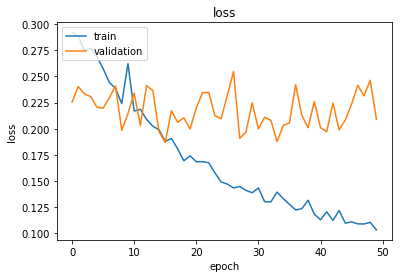

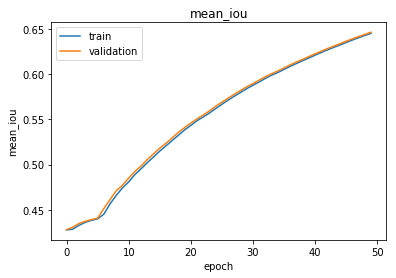

In [12]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(acc)
plt.plot(val_acc )
plt.title('mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

6/6 [==============================] - 0s     
(6, 256, 256, 1) (6, 256, 256, 1)
(256, 256, 1)
0.0 1.0


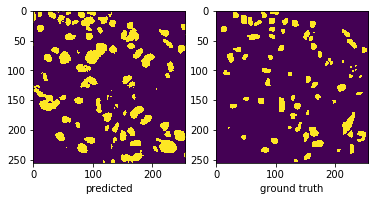

(256, 256, 1)
0.0 1.0


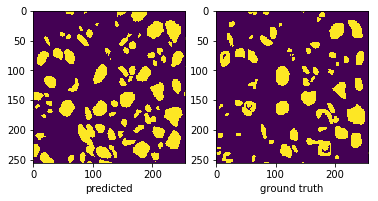

(256, 256, 1)
0.0 1.0


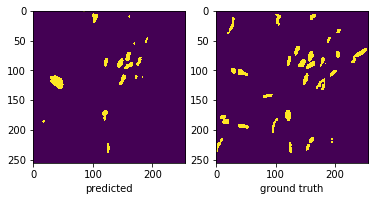

(256, 256, 1)
0.0 1.0


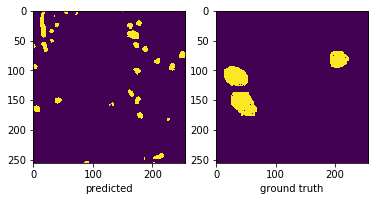

(256, 256, 1)
0.0 1.0


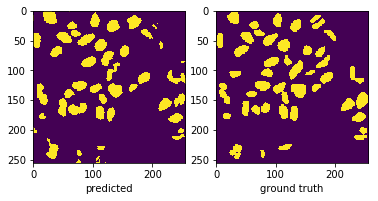

(256, 256, 1)
0.0 1.0


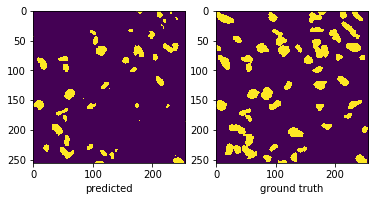

In [14]:
imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
np.save('imgs_mask_test.npy', imgs_mask_test)

import skimage
from skimage.io import *
from skimage.color import *

from skimage.filters import threshold_otsu

n = 0 


print(imgs_mask_test.shape, y_test.shape)
for i in imgs_mask_test:
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    print(i.shape)
    #thresh = threshold_otsu(i)
    #i = i > thresh
    i[i > 0.5] = 1
    i[i<=0.5] =0
    #i[i>100] = 255
    print(i.min(),i.max())
    i = i.reshape((256,256))

    j = y_test[n].reshape((256,256))

    ax1.imshow(i)
    ax2.imshow(j)
    ax2.set_xlabel("ground truth")
    ax1.set_xlabel("predicted")
    n +=1
    plt.show()

In [22]:
def my_func(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return tf.matmul(arg, arg) + arg

m_iou = mean_iou(my_func(imgs_mask_test.reshape((6,256,256))), my_func(y_test.reshape((6,256,256))))
m_iou

<tf.Tensor 'Mean_2:0' shape=() dtype=float32>

In [ ]:
from keras import backend as K
#K.clear_session()